<a href="https://colab.research.google.com/github/Ken-huea/Time-series-analysis/blob/main/sarima%E3%81%BE%E3%81%A8%E3%82%81.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## 実装
SARIMAモデルを用いて車の月の売上を予測しましょう。

### データの読込

In [ ]:
#モジュールのインポート
import warnings
import itertools
import pandas as pd
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt
%matplotlib inline

# 1.データの読み込み
df = pd.read_csv("/content/SARIMA実装.csv")

# 読込後の確認
print(df.shape)
df.head(5)


(108, 2)


,Month,sales
0,1960-01,6550
1,1960-02,8728
2,1960-03,12026
3,1960-04,14395
4,1960-05,14587


### データ整形

In [ ]:
# 日付を月ごとにしてindexにdatetime型に格納する。⇒時系列解析のデータ整形。
index = pd.date_range("1960-01-31","1968-12-31",freq="M")
df.index=index

# 日付がindexに格納されている事をご確認下さい
df.head(5)

,Month,sales
1960-01-31,1960-01,6550
1960-02-29,1960-02,8728
1960-03-31,1960-03,12026
1960-04-30,1960-04,14395
1960-05-31,1960-05,14587


In [ ]:
# 上記の整形により不要になったカラム["Month"]の削除
del df["Month"]

df.head(5)

,sales
1960-01-31,6550
1960-02-29,8728
1960-03-31,12026
1960-04-30,14395
1960-05-31,14587


### データ分割

In [ ]:
# データ数(len)*0.7をintに変換 その後に：で範囲を指定。 lenとintとlistの複合技です。

train=df[:int(len(df)*0.7)] # この長さまで。
test=df[int(len(df)*0.7):] # この長さ以降。

In [ ]:
#それぞれ確認してください。
train.head(5)
test.head(5)

,sales
1966-04-30,22135
1966-05-31,20677
1966-06-30,19933
1966-07-31,15388
1966-08-31,15113


### 学習と精度評価

SARIMAにはいくつかのハイパーパラメータがあります。　その調整はPCにやってもらいましょう。

In [ ]:
#グリッドサーチ
import itertools
from statsmodels.tsa.statespace.sarimax import SARIMAX


p = q = range(0, 3)              # パラメータpとqの範囲を指定。
sp = sd = sq = range(0, 2)       # パラメータ sp/sd/sq の範囲を指定。

pdq = [(x[0], 1, x[1]) for x in list(itertools.product(p, q))] # 3*3 9パターン

seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(sp, sd, sq))] # 2*2*2 8パターン　　72パターン。

# worningの無視。例外処理を行います。
import warnings
warnings.filterwarnings("ignore")

# AICが低かったら更新する。という事ですね。

best_result = [0, 0, 10000000]
for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod = SARIMAX(train, order = param, seasonal_order = param_seasonal)
            results = mod.fit()
            print('ARIMAパラメータ{}, 季節変動パラメータ{} - AIC: {}'.format(param, param_seasonal, results.aic))
            
            if results.aic < best_result[2]:
                best_result = [param, param_seasonal, results.aic]
        except:
            continue

print('AIC最小のモデル：', best_result)

学習と結果表示。

基本的にはAICを見ると良いです。その値が小さいと良い予測が出来ていると思って頂ければ

In [ ]:
#パラメータの設定. 学習用データ train_Xを格納
sarima_model2 = SARIMAX(train,order=(1,1,1),seasonal_order=(1,1,0,12))

#モデルフィット。インスタンス化
sarima_model2 = sarima_model2.fit()
sarima_model2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                      
===========================================================================================
Dep. Variable:                               sales   No. Observations:                   75
Model:             SARIMAX(1, 1, 1)x(1, 1, [], 12)   Log Likelihood                -542.107
Date:                             Sat, 10 Sep 2022   AIC                           1092.214
Time:                                     04:32:17   BIC                           1100.723
Sample:                                 01-31-1960   HQIC                          1095.555
                                      - 03-31-1966                                         
Covariance Type:                               opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.2381      0.124      1.919      0.055      -0.005       0.481
ma.L1         -0.9993      0.170     -5.877      0.000      -1.333      -0.666
ar.S.L12      -0.4687      0.121     -3.882      0.000      -0.705      -0.232
sigma2      1.938e+06    8.7e-08   2.23e+13      0.000    1.94e+06    1.94e+06
===================================================================================
Ljung-Box (L1) (Q):                   0.10   Jarque-Bera (JB):                 2.22
Prob(Q):                              0.75   Prob(JB):                         0.33
Heteroskedasticity (H):               0.85   Skew:                             0.45
Prob(H) (two-sided):                  0.72   Kurtosis:                         3.22
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 3.08e+28. Standard errors may be unstable.
"""

In [ ]:
test

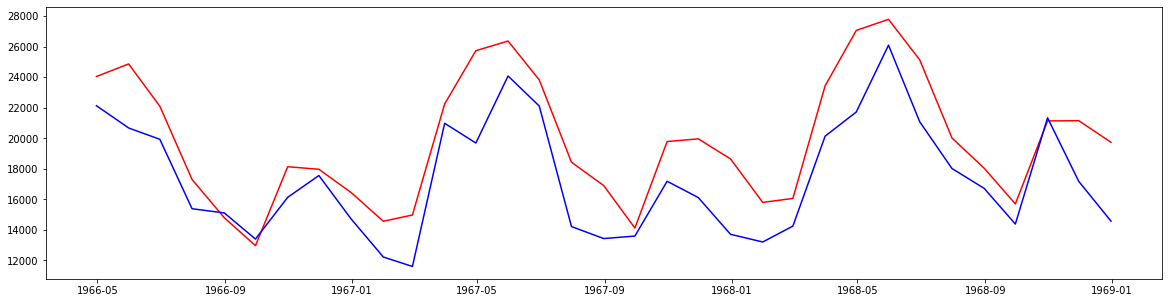

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.figure(figsize=(20,5))

# 予測⇒どの期間を予測するのかはtestで確認して下さい。 ⇒ 日付がtestとpred双方とも合致していると確認。
pred = sarima_model2.predict("1966-4-3","1968-12-31")

#1つ目のデータをplotメソッドでプロット
plt.plot(pred, color = 'red')

#2つ目のデータをplotメソッドでプロット
plt.plot(test, color = 'blue')
plt.legend()
plt.show()

In [ ]:
import numpy as np
from sklearn.metrics import mean_squared_error as MSE
# y_trainと予測値のRMSEを出す
print("RMSE",np.sqrt(MSE(test,pred)))

RMSE 2989.6242754504356
